In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from utils import img_parts_generator
import pickle
import scipy
import os
import math
import cv2

Using TensorFlow backend.


In [2]:
def plot_data(img, body_point=None, head_point=None):

    implot = plt.imshow(img)
    if(body_point and head_point):
        plt.plot([body_point[0], head_point[0]], [body_point[1], head_point[1]],'o', marker=5)
    plt.show()


In [3]:
def plot_data_bb(img, t_l_x, t_l_y, b_r_x, b_r_y):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)
    width = b_r_x - t_l_x
    height = b_r_y - t_l_y
    # Create a Rectangle patch
    rect = patches.Rectangle((t_l_x, t_l_y), width, height,linewidth=2,edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

In [4]:
def plot_data_new(img, t_l, b_l, t_r, b_r):

    implot = plt.imshow(img)
    if(body_point and head_point):
        plt.plot([t_l[0], b_l[0], t_r[0], b_r[0]], [t_l[1], b_l[1], t_r[1], b_r[1]],'o', marker=5)
    plt.show()


In [27]:
def rotate_image(img, body_point, head_point, target_angle, pivot):
    
    head_x = head_point[0]
    head_y = head_point[1]
    body_x = body_point[0]
    body_y = body_point[1]
    
    ydiff = float(-head_y + body_y)
    xdiff = (head_x - body_x)
    
    slope = ydiff/xdiff
    image_angle = math.degrees(math.atan(slope))
    if ydiff>=0 and xdiff >= 0:
        image_angle = image_angle
    elif ydiff >=0:
        image_angle = 180 + image_angle
    elif xdiff >=0:
        image_angle = 360 + image_angle
    else:
        image_angle = 180 + image_angle

    #img = np.fliplr(img)
    #flipped = True
    #image_angle = np.abs(image_angle)
    head_point = rotate_point(head_x, head_y, target_angle, pivot)
    #body_point = rotate_point(body_x, body_y, target_angle, pivot)
    print(head_point, body_point)
    image_center = pivot
    rot_mat = cv2.getRotationMatrix2D(image_center,-image_angle+target_angle, 1.0)

    img = cv2.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]),flags=cv2.INTER_LINEAR)
    
    head_x = head_point[0]
    head_y = head_point[1]
    body_x = body_point[0]
    body_y = body_point[1]
    ydiff = float(-head_y + body_y)
    xdiff = (head_x - body_x)
    slope = ydiff/xdiff
    image_angle = math.degrees(math.atan(slope))
    flipped = False
    if image_angle < 0:
        flipped = True
        img = np.fliplr(img)
    
    return img, image_angle, flipped

In [6]:
def flip_image_if_needed(img, parts):
    beak_x = parts[6]
    left_eye_x = parts[18]
    if beak_x != -1 and left_eye_x != -1 and beak_x < left_eye_x:
        return np.fliplr(img), True
    else:
        return img, False

In [7]:
def get_save_path(path):
    save_img_dir = "/".join([save_path] + path[3:].split('/')[:2])
    if not os.path.exists(save_img_dir):
        os.makedirs(save_img_dir)
    save_img_path = save_path + path[2:]
    return save_img_path

In [8]:
def crop(img, t_l_x, t_l_y, b_r_x, b_r_y):
    return img[t_l_y:b_r_y, t_l_x:b_r_x]

In [9]:
def resize(img, target_dim):
    return scipy.misc.imresize(img, target_dim)

In [10]:
def get_bird_body_head_location(parts):
    body_x = []
    body_y = []
    head_x = []
    head_y = []
    for i in range(4, len(parts)):
        if parts[i] != -1:
            if i%2 == 0:
                if(i/2 in body_index):
                    body_x.append(parts[i])
                elif(i/2 in head_index):
                    head_x.append(parts[i])
                else:
                    print("Location neither bodyx nor headx: ", i)
            else:
                if(i//2 in body_index):
                    body_y.append(parts[i])
                elif(i//2 in head_index):
                    head_y.append(parts[i])
                else:
                    print("Location neither bodyy nor heady: ", i)
    return (np.mean(body_x),np.mean(body_y)) , (np.mean(head_x),np.mean(head_y))

In [11]:
part_file_name = 'parts_info.txt'
validation_data_dir = 'validation/'
batch_size = 1
steps=4
target_dim=None
cache=False
save_path = '../cropped_trained_aligned'
target_angle = 50

In [21]:
def rotate_point(p_x, p_y, angle, pivot):
    center = pivot
    top_left_distance = math.hypot(center[0] - p_x, center[1] - p_y)
    
    ydiff = float(-p_y+center[1])
    xdiff = float(p_x-center[0])
    
    top_left_slope = ydiff/ xdiff
    top_left_angle = math.degrees(math.atan(top_left_slope))
    if ydiff>=0 and xdiff >= 0:
        top_left_angle = top_left_angle
    elif ydiff >=0:
        top_left_angle = 180 + top_left_angle
    elif xdiff >=0:
        top_left_angle = 360 + top_left_angle
    else:
        top_left_angle = 180 + top_left_angle
    top_left_angle = top_left_angle - angle
    p_x = center[0] + top_left_distance * math.cos(math.radians(top_left_angle))
    p_y = center[1] - top_left_distance * math.sin(math.radians(top_left_angle))
    return (p_x, p_y)

In [29]:
validation_generator = img_parts_generator(part_file_name, validation_data_dir, batch_size=10, load_image=True, steps=steps, target_dim=target_dim, cache=False, load_paths=True, load_parts=True, bb_only=False)

In [30]:
body_index = set([2, 4, 5, 10, 11, 15, 16, 17])
head_index = set([3, 6, 7, 8, 9, 12, 13, 14, 18])

(1560.5999999999999, 1150.4000000000001) (1487.0, 751.0)


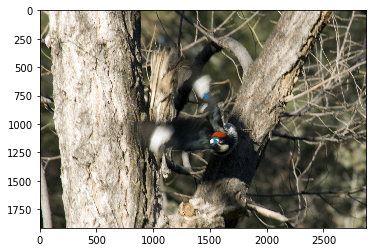

(1228.3510174912094, 1064.1102423223606) (1487.0, 751.0)


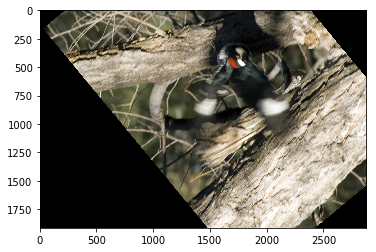

Img:  50.441126531271344


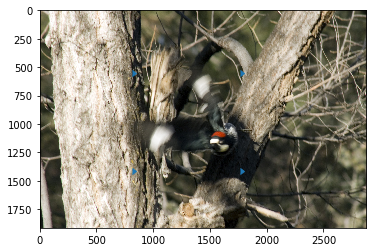

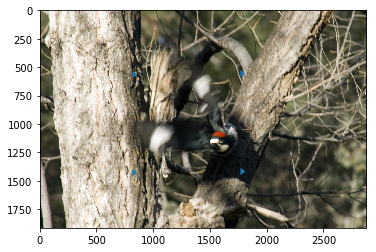

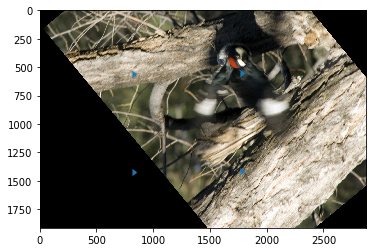

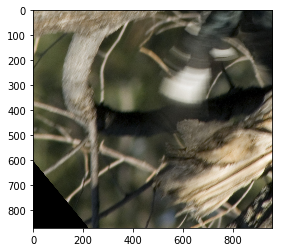

(1086.8571428571429, 584.14285714285711) (1073.3333333333333, 709.33333333333337)


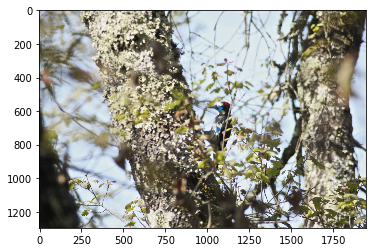

(1177.9277391481319, 639.22228552285139) (1073.3333333333333, 709.33333333333337)


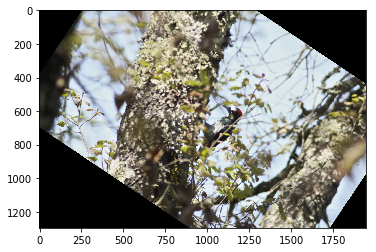

Img:  33.83448267240115


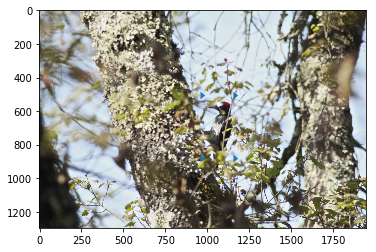

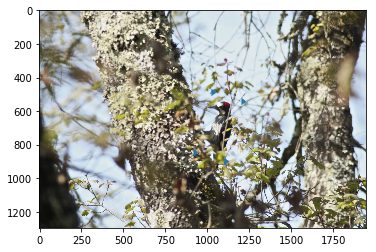

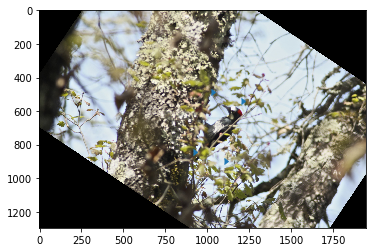

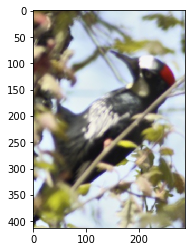

(1194.8571428571429, 464.0) (1444.1428571428571, 934.0)


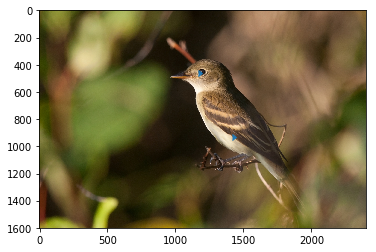

(1643.9459769940609, 440.92588726980989) (1444.1428571428571, 934.0)


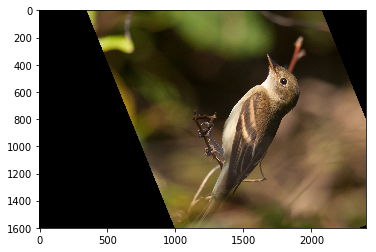

Img:  67.94126163964462


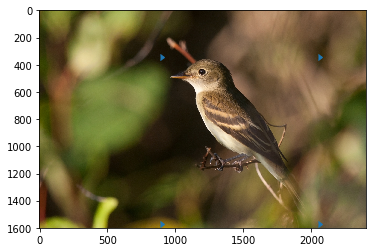

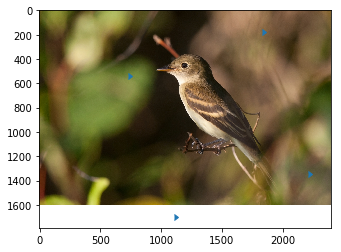

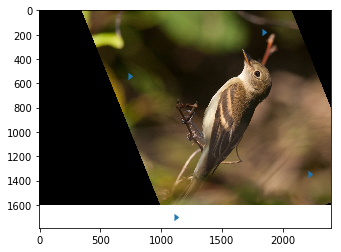

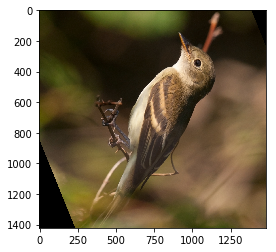

(737.0, 367.28571428571428) (814.0, 513.39999999999998)


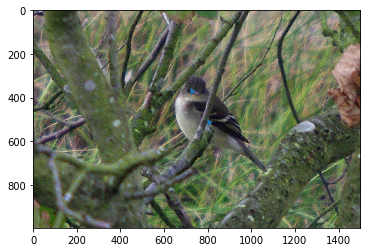

(876.43539068586369, 360.49412542449693) (814.0, 513.39999999999998)


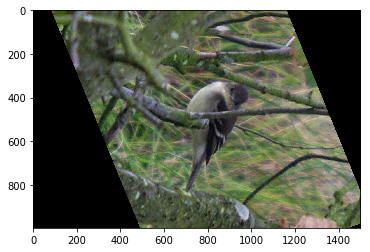

Img:  67.78854660615103


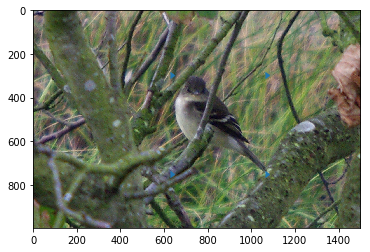

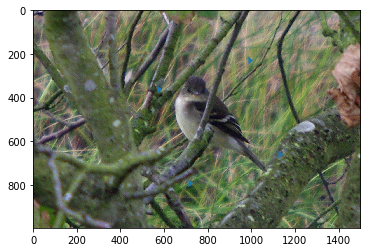

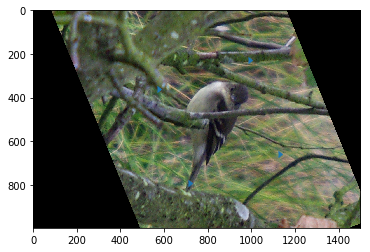

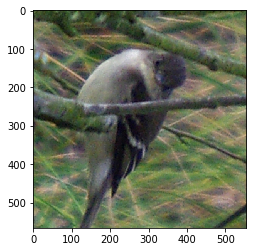

(408.14285714285717, 379.85714285714283) (381.5, 711.16666666666663)


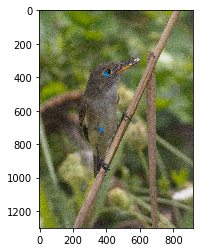

(652.42351812475749, 518.61462245385565) (381.5, 711.16666666666663)


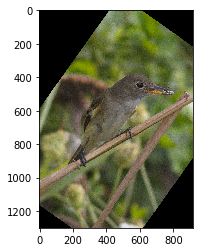

Img:  35.4023495796441


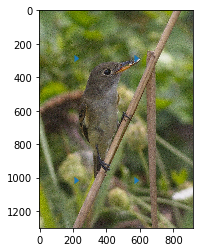

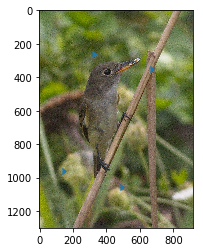

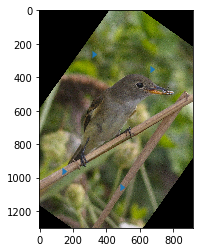

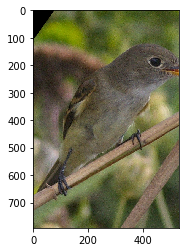

(777.57142857142856, 338.0) (613.25, 838.25)


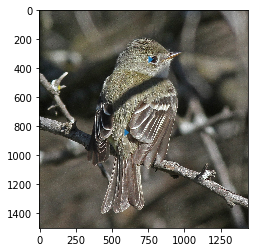

(1102.0875109619747, 642.57301549682359) (613.25, 838.25)


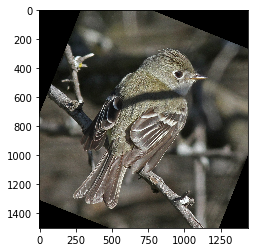

Img:  21.815753944579683


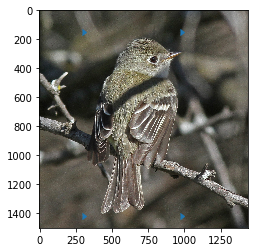

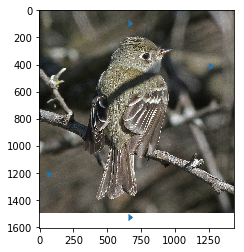

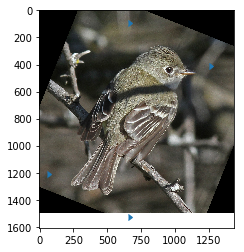

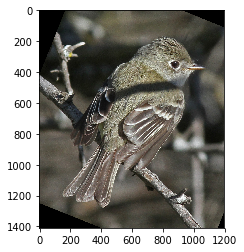

(356.14285714285717, 221.42857142857142) (360.25, 323.5)


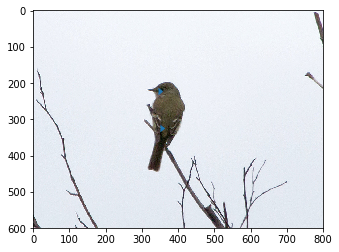

(435.80123011857461, 254.74349644847103) (360.25, 323.5)


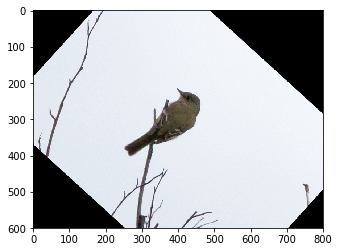

Img:  42.30422044204325


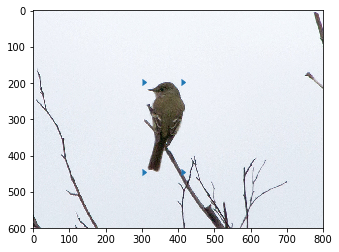

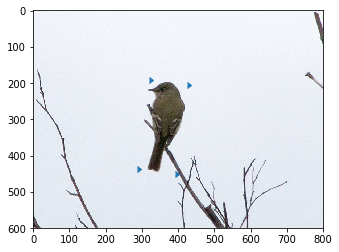

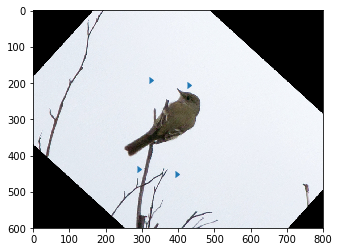

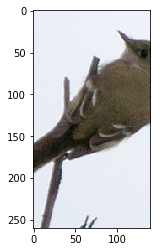

(320.25, 186.25) (422.25, 504.75)


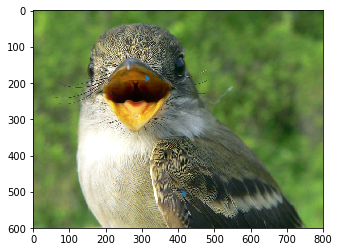

(600.67081894536761, 221.88561311670156) (422.25, 504.75)


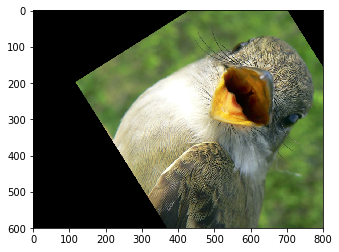

Img:  57.75772528536829


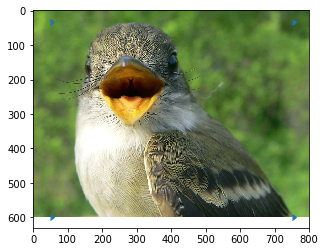

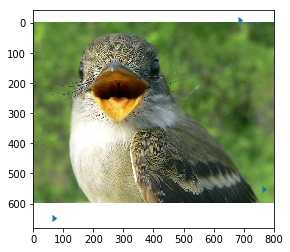

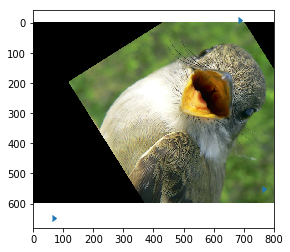

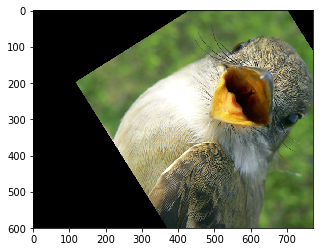

(848.14285714285711, 571.71428571428567) (715.5, 633.5)


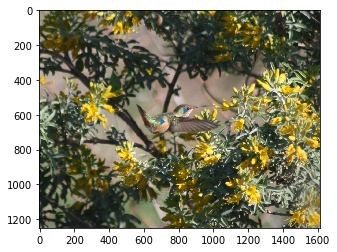

(848.09178817755856, 695.39523203522037) (715.5, 633.5)


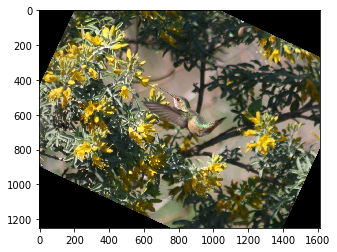

Img:  -25.023657936783774


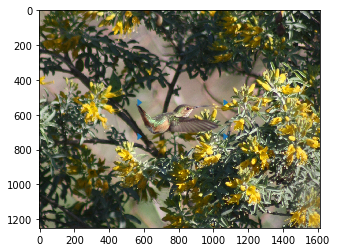

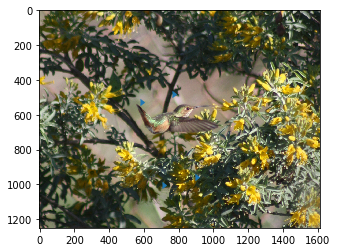

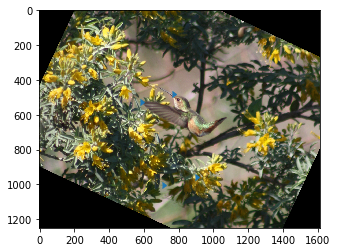

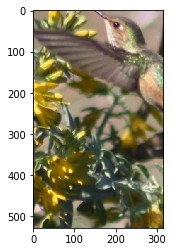

(253.85714285714286, 489.42857142857144) (346.33333333333331, 611.66666666666663)


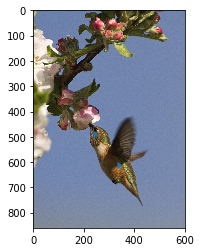

(380.53059749881697, 462.25266178083803) (346.33333333333331, 611.66666666666663)


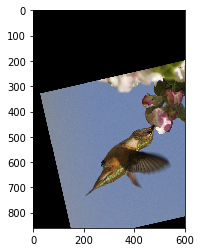

Img:  77.10842101174826


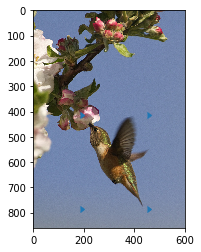

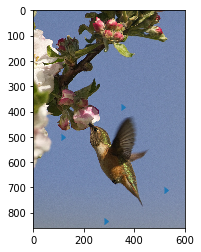

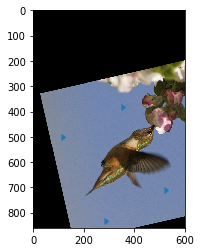

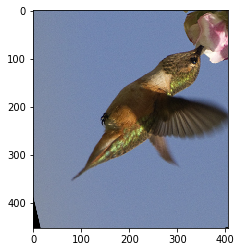

In [32]:
for imgs, paths, parts in validation_generator:
    for i in range(len(imgs)):
        
        img = imgs[i]
        path = paths[i]

        t_l_x = parts[i][0]
        t_l_y = parts[i][1]
        b_r_x = parts[i][2]
        b_r_y = parts[i][3]
        
        body_point, head_point = get_bird_body_head_location(parts[i])
        print(head_point, body_point)
        plot_data(img, body_point, head_point)
        
        #img, flipped = flip_image_if_needed(img, parts[i])
        img2 = img
        pivot = body_point
        img, image_angle, flipped = rotate_image(img, body_point, head_point, target_angle, pivot)
        plot_data(img)
        print("Img: ", image_angle)
        if flipped:
            y, x, rgb = img.shape
            temp = t_l_x
            t_l_x = x - b_r_x
            b_r_x = x - temp
        t_l = rotate_point(t_l_x, t_l_y, target_angle - image_angle, pivot)
        b_l = rotate_point(t_l_x, b_r_y, target_angle - image_angle, pivot)
        t_r = rotate_point(b_r_x, t_l_y, target_angle - image_angle, pivot)
        b_r = rotate_point(b_r_x, b_r_y, target_angle - image_angle, pivot)
        
        
        #plot_data_new(img, t_l, b_l, t_r, b_r)
        
        plot_data_new(img2, (t_l_x, t_l_y), (b_r_x, b_r_y), (t_l_x, b_r_y), (b_r_x, t_l_y))
        plot_data_new(img2, t_l, b_r, b_l, t_r)
        plot_data_new(img, t_l, b_r, b_l, t_r)
        t_l_x = int(max(min(t_l[0], b_l[0]), 0))
        t_l_y = int(max(min(t_l[1], t_r[1]), 0))
        b_r_x = int(min(max(t_r[0], b_r[0]), img.shape[1]))
        b_r_y = int(min(max(b_l[1], b_r[1]), img.shape[0]))
        
        #plot_data_bb(img, t_l_x, t_l_y, b_r_x, b_r_y)
        #print(t_l_x, t_l_y, b_r_x, b_r_y)
        img = crop(img, t_l_x, t_l_y, b_r_x, b_r_y)
        plot_data(img)
        
        #resized_cropped_img = resize(crop_img, (299, 299))
        #plot_data(resized_cropped_img)
        
        #save_img_path = get_save_path(path)
        
        #image = Image.fromarray(resized_cropped_img)
        #image.save(save_img_path)
    break
        